In [ ]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive as cdrive
from keras.preprocessing.image import save_img

cdrive.mount('/content/gdrive')

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed);

Mounted at /content/gdrive
Random Seed:  999


In [ ]:
# Root directory for dataset, add gdrive/My Drive/ for Google Drive
dataroot = "gdrive/My Drive/tiny_dataset"
# Number of workers for dataloader
workers = 4
# Batch size during training
batch_size = 128
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128
# Number of channels in the training images. 1 in this case,
# for greyscale images
nc = 1
# Size of z latent vector (i.e., size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator,
# set to a fraction of ngf to reach convergence
ndf = ngf // 4
# Number of training epochs
num_epochs = 5
# Learning rate for optimizers, according to paper by Radford et al.
lr = 0.0002
# Beta1 hyperparam for Adam optimizers, according to paper by Radford et al.
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Whether to use minimax loss or Wasserstein loss
w_loss = False
# Whether to add noise to input to the discriminator
add_noise = False

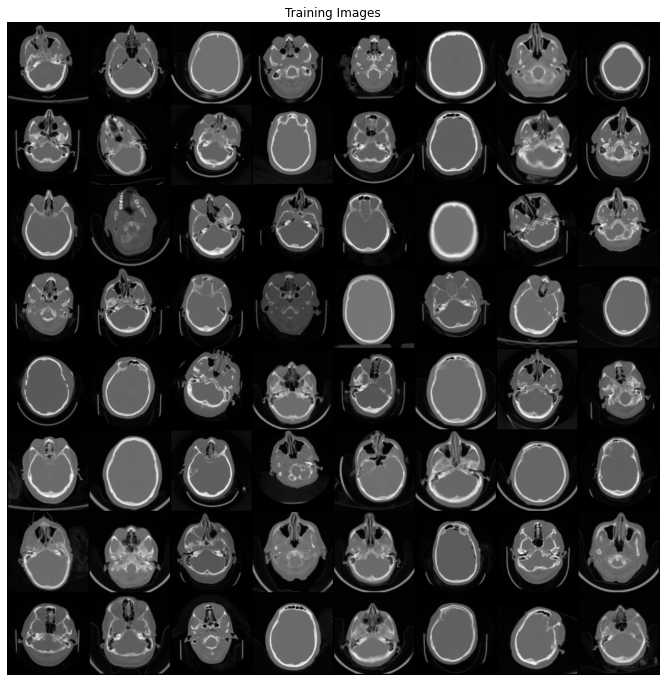

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset. Resize, center crop, greyscale, convert to tensors
# and normalize the images to mean = 0.5 and stdev = 0.5
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(num_output_channels=1),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5], [0.5])]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images and save them to disk
first_batch = next(iter(dataloader))
plt.figure(figsize=(12,12))
plt.axis("off")
plt.title("Training Images")
training_imgs = np.transpose(vutils.make_grid(first_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0))
plt.imshow(training_imgs)
plt.show()
save_img('training_images.png', training_imgs)

In [ ]:
# custom weights initialization called on netG and netD,
# according to Radford et al.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code - architecture for images of size 128x128
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input size = 1x1x100, output size = 4x4x2048
            nn.ConvTranspose2d(nz, ngf * 16, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # input size = 4x4x2048, output size = 8x8x1024
            nn.ConvTranspose2d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # input size = 8x8x1024, output size = 16x16x512
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # input size = 16x16x512, output size = 32x32x256
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # input size = 32x32x256, output size = 64x64x128
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # input size = 64x64x128, output size = 128x128x1
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)
# Print the number of batches
print(len(dataloader))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ba

In [ ]:
# Discriminator architecture for images of size 128x128
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input size = 128x128x1, output size = 64x64x32
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # input size = 64x64x32, output size = 32x32x128
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # input size = 32x32x128, output size = 16x16x256
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # input size = 16x16x256, output size = 8x8x512
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # input size = 8x8x512, output size = 4x4x1024
            nn.Conv2d(ndf * 8, ndf * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # input size = 4x4x1024, output size = 1x1x1
            nn.Conv2d(ndf * 16, 1, kernel_size=4, stride=1, padding=0, bias=False)
        )

        self.output = nn.Sequential(
            nn.Sigmoid()
        )

    def forward(self, input):
        x = self.main(input)
        if not w_loss:
          x = self.output(x)
        return x

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, mom

In [ ]:
# For minimax loss
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(size=(64, nz, 1, 1), device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup optimizers for both G and D, Adam for minimax loss and 
# RMSprop for Wasserstein loss
if w_loss:
  optimizerD = optim.RMSprop(netD.parameters(), lr=5e-5)
  optimizerG = optim.RMSprop(netG.parameters(), lr=5e-5)
else:
  optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
  optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
torch.autograd.set_detect_anomaly(True)
# Load trained model's dicts to set up checkpoints 
# during training 
netD.load_state_dict(torch.load('gdrive/My Drive/discriminator_250.pt'))
netG.load_state_dict(torch.load('gdrive/My Drive/generator_250.pt'))

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update Discriminator: train on real images first and then fake 
        # images
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        input = data[0].to(device)
        b_size = input.size(0)
        if add_noise:
          # Generate noise to add to images
          white_noise = torch.autograd.Variable(input.data.new(input.size()).normal_(0.5, 0.5))
          # Add noise to real images
          input = input + white_noise
        labels = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through discriminator
        output = netD(input)
        # Flatten
        output = output.view(-1)
        if w_loss:
          loss_D = output
          loss_D.backward(labels)
        else:
          # Calculate loss on all-real batch
          errD_real = criterion(output, labels)
          # Calculate gradients for discriminator in backward pass
          errD_real.backward()
          D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        input = netG(noise)
        fake = input.detach().clone()
        if add_noise:
          # Add noise to fake images
          input = input + white_noise
        labels.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(input.detach()).view(-1)
        if w_loss:
          loss_D = output
          loss_D.backward(labels)
        else:
          # Calculate D's loss on the all-fake batch
          errD_fake = criterion(output, labels)
          # Calculate the gradients for this batch
          errD_fake.backward()
          D_G_z1 = output.mean().item()
          # Add the gradients from the all-real and all-fake batches
          errD = errD_real + errD_fake
        # Update discriminator
        optimizerD.step()
        # For Wasserstein loss, clip weights
        # to fix them into a constrained range
        if w_loss:
          for p in netD.parameters():
              p.data.clamp_(-0.01, 0.01)

        # For Wasserstein loss, train the discriminator more
        # than the generator
        if w_loss and i % 5 != 0:
          continue

        ############################
        # (2) Update G network: forward-pass fake images on discriminator,
        # backpropagate in generator w.r.t. that loss
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        if w_loss:
          loss_G = output
          loss_G.backward(labels)
        else:
          # Calculate G's loss based on this output
          errG = criterion(output, labels)
          # Calculate gradients for G
          errG.backward()
          D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if w_loss:
          if i % 50 == 0:
              print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                    % (epoch, num_epochs,
                      loss_D.mean().item(), loss_G.mean().item()))
        else:
          if i % 50 == 0:
              print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                      errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
              
        # Save Losses for plotting later
        if w_loss:
          G_losses.append(loss_G.mean().item())
          D_losses.append(loss_D.mean().item())
        else:
          G_losses.append(errG.item())
          D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

# save models' dicts for checkpoints
torch.save(netD.state_dict(), 'discriminator.pt')
torch.save(netG.state_dict(), 'generator.pt')

[0/5][0/11]	Loss_D: 0.6057	Loss_G: 8.2184	D(x): 0.9005	D(G(z)): 0.3766 / 0.0004
[1/5][0/11]	Loss_D: 0.1979	Loss_G: 3.0401	D(x): 0.9137	D(G(z)): 0.0948 / 0.0634
[2/5][0/11]	Loss_D: 0.0935	Loss_G: 3.7402	D(x): 0.9533	D(G(z)): 0.0408 / 0.0350
[3/5][0/11]	Loss_D: 0.0752	Loss_G: 3.8993	D(x): 0.9540	D(G(z)): 0.0262 / 0.0332
[4/5][0/11]	Loss_D: 0.0426	Loss_G: 4.9725	D(x): 0.9838	D(G(z)): 0.0236 / 0.0118


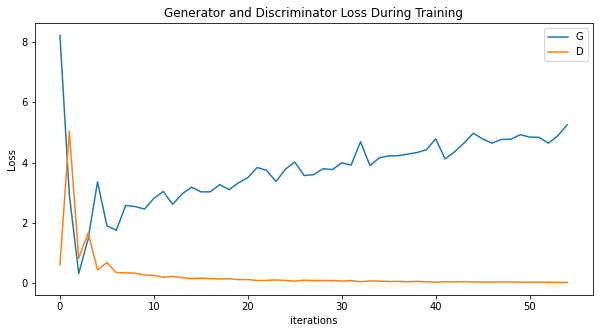

In [ ]:
# Plot generator's and discriminator's loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

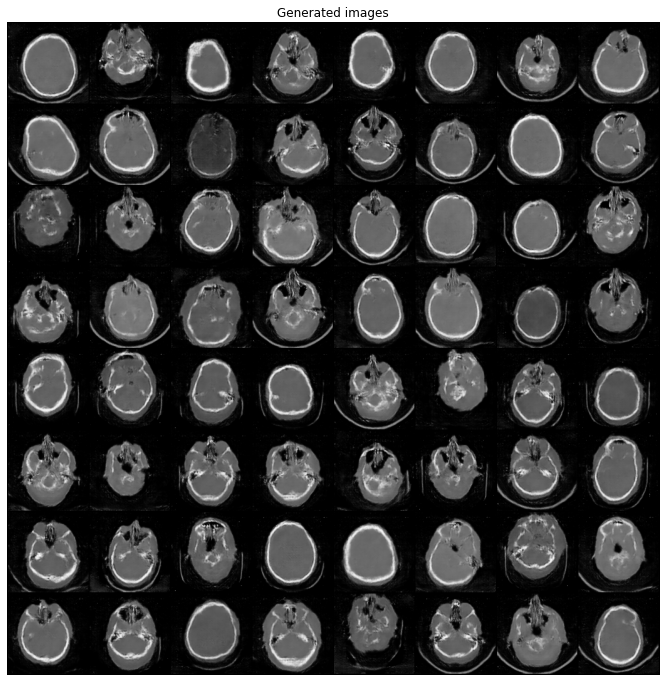

In [ ]:
# Plot and save generated images
fig = plt.figure(figsize=(12,12))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
plt.title('Generated images')
plt.show()
for idx, img in enumerate(img_list):
  save_img('img_' + str(idx) + '.png', np.transpose(img,(1,2,0)))

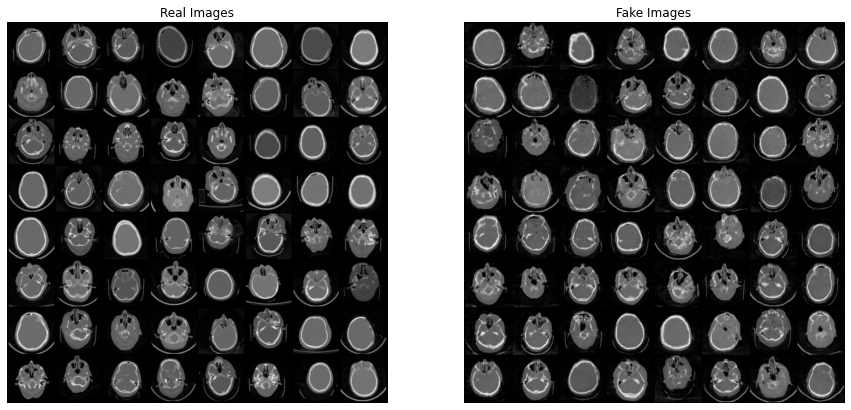

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()